In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [3]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import time

from PIL import Image
from IPython.display import display

import tensorflow as tf
from tensorflow.keras import layers, models

from build_model_ed import build_model_1, build_model_2
from get_frames import get_frames

In [4]:
#gpu check
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
#load data
test_size = 0.1
stride_step = 50
norm_factor=1
dtype = 'uint8'

filename = f'save_data/e_d_train_all_str_{stride_step}_ts_{test_size}_{dtype}_norm_{norm_factor}.pkl'
filename = f'save_data/e_d_train_Puck_str_{stride_step}_ts_{test_size}_{dtype}_norm_{norm_factor}.pkl'
filename = f'save_data/e_d_test_Puck_str_{stride_step}_ts_{test_size}_{dtype}_norm_{norm_factor}.pkl'
#load data
with open(filename, 'rb') as f:
    test_list,frames_data_test = pickle.load(f)
    
print(f'Training dataset shape: {frames_data_test.shape}')
print(f'Training dataset dtype: {frames_data_test.dtype}')

Training dataset shape: (3200, 2048, 50, 3)
Training dataset dtype: uint8


In [6]:
model_names_list = [
    'model_encoder_decoder_test', 
    'model_encoder_decoder_test_2', 
    'model_encoder_decoder_test_3'
]

ifPrint = False
ifSummary = True

model_dict = {}

for model_name in model_names_list:
    print(f'\nModel name: {model_name}')
    filename = f'saved_models/{model_name}_settings.pkl'
    #load data
    with open(filename, 'rb') as f:
        dense_units,ifBatchNorm,kernel_size,nn_blocks = pickle.load(f)
        
    input_shape = frames_data_test.shape[1:]

    if ifPrint:
        print(f'Dense units: {dense_units}')
        print(f'ifBatchNorm: {ifBatchNorm}')
        print(f'Kernel size: {kernel_size}')
        nn_blocks_print = "\n".join(map(str, nn_blocks))
        print(f'NN blocks (filters, kernel, ifBatchNorm, MaxPooling): \n{nn_blocks_print}')
        print(f'Input shape: {input_shape}')

    loss = 'mean_squared_error'
    optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.1, name="Adadelta")
    #optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.01, name="SGD")


    model = build_model_2(input_shape, dense_units, nn_blocks)
    model.compile(loss=loss, 
                  optimizer=optimizer, )
    
    if ifSummary:
        model.summary() 

    model.load_weights(f'saved_models/{model_name}/{model_name}').expect_partial()  
    model_dict[model_name] = model
    print('\n\n\n')


Model name: model_encoder_decoder_test
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2048, 50, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 2048, 50, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 2048, 50, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 2048, 50, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 512, 50, 16)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)   

 max_pooling2d_7 (MaxPoolin  (None, 32, 50, 128)       0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 204800)            0         
                                                                 
 dense_2 (Dense)             (None, 100)               20480100  
                                                                 
 dense_3 (Dense)             (None, 204800)            20684800  
                                                                 
 reshape_1 (Reshape)         (None, 32, 50, 128)       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 50, 128)       147584    
                                                                 
 batch_normalization_12 (Ba  (None, 32, 50, 128)       512       
 tchNormalization)                                               
          

 batch_normalization_23 (Ba  (None, 512, 50, 16)       64        
 tchNormalization)                                               
                                                                 
 up_sampling2d_11 (UpSampli  (None, 2048, 50, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 2048, 50, 3)       435       
                                                                 
 rescaling_5 (Rescaling)     (None, 2048, 50, 3)       0         
                                                                 
Total params: 20875659 (79.63 MB)
Trainable params: 20874699 (79.63 MB)
Non-trainable params: 960 (3.75 KB)
_________________________________________________________________






In [7]:
#run on test set

for model_name in model_dict.keys():
    model = model_dict[model_name]
    batch_size = 2
    score = model.evaluate(frames_data_test, frames_data_test, batch_size=batch_size)
    print(f"Model: {model_name}\nTest score: {score}\n")

1600/1600 [==============================] - 5s 3ms/step - loss: 110.7648
Model: model_encoder_decoder_test
Test score: 110.76478576660156

1600/1600 [==============================] - 5s 3ms/step - loss: 149.0392
Model: model_encoder_decoder_test_2
Test score: 149.03915405273438

1600/1600 [==============================] - 4s 3ms/step - loss: 102.2904
Model: model_encoder_decoder_test_3
Test score: 102.2903823852539




Model name: model_encoder_decoder_test
1/1 [==============================] - 1s 649ms/step

Model name: model_encoder_decoder_test_2
1/1 [==============================] - 0s 282ms/step

Model name: model_encoder_decoder_test_3
1/1 [==============================] - 0s 125ms/step


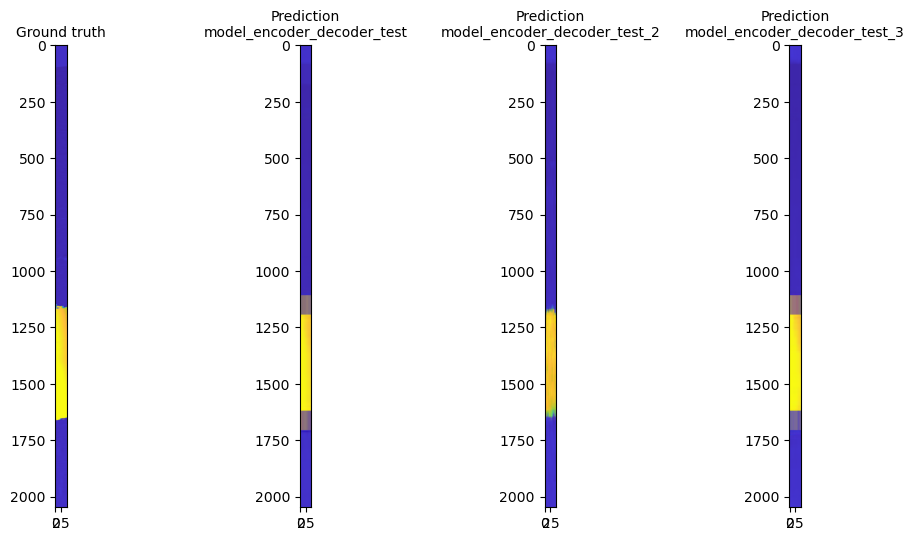

In [8]:
#compare results for the chosen fram from the test set
frame_index = 101

#get frame
frame_to_predict = frames_data_test[frame_index]

numb_col = len(model_dict.keys())+1               
fig, axes = plt.subplots(1,numb_col, figsize=(3*numb_col,6))
fig.subplots_adjust(hspace=0.2, wspace=0.25)
linewidth = 3.0
fontsize_sec = 12
                         
ax = axes[0]
ax.imshow(frame_to_predict)
ax.set_title(f'Ground truth', fontsize=fontsize_sec-2)
                         

for i, model_name in enumerate(model_dict.keys()):
    model = model_dict[model_name]
    print(f'\nModel name: {model_name}')
    #make prediction
    frame_predicted = model.predict(np.expand_dims(frame_to_predict, axis=0))
    #change dtype to int
    #TODO fix scaler layer of a NN to output int not float
    frame_predicted = frame_predicted[0].astype(int)
    
    ax = axes[i+1]
    ax.imshow(frame_predicted)
    ax.set_title(f'Prediction\n{model_name}', fontsize=fontsize_sec-2)

In [16]:
test_list

['Pucker29.png', 'Pucker10.png', 'Pucker12.png', 'Pucker14.png']

Chosen test case: Pucker29.png

Image shape: (2048, 4000, 3)
Framed image shape: (80, 2048, 50, 3)

Model name: model_encoder_decoder_test
##########Prediction started#############
##########Image predicted#############
Time for prediction (whole image): 3.55 sec

Reshaping separate frames into a single image
Image shape after 1st reshape: (80, 50, 2048, 3)
Image shape after 2st reshape: (4000, 2048, 3)
Image shape after final reshape: (2048, 4000, 3)
Time for image assembly: 0.09 sec

Model name: model_encoder_decoder_test_2
##########Prediction started#############
##########Image predicted#############
Time for prediction (whole image): 3.37 sec

Reshaping separate frames into a single image
Image shape after 1st reshape: (80, 50, 2048, 3)
Image shape after 2st reshape: (4000, 2048, 3)
Image shape after final reshape: (2048, 4000, 3)
Time for image assembly: 0.08 sec

Model name: model_encoder_decoder_test_3
##########Prediction started#############
##########Image predicted########

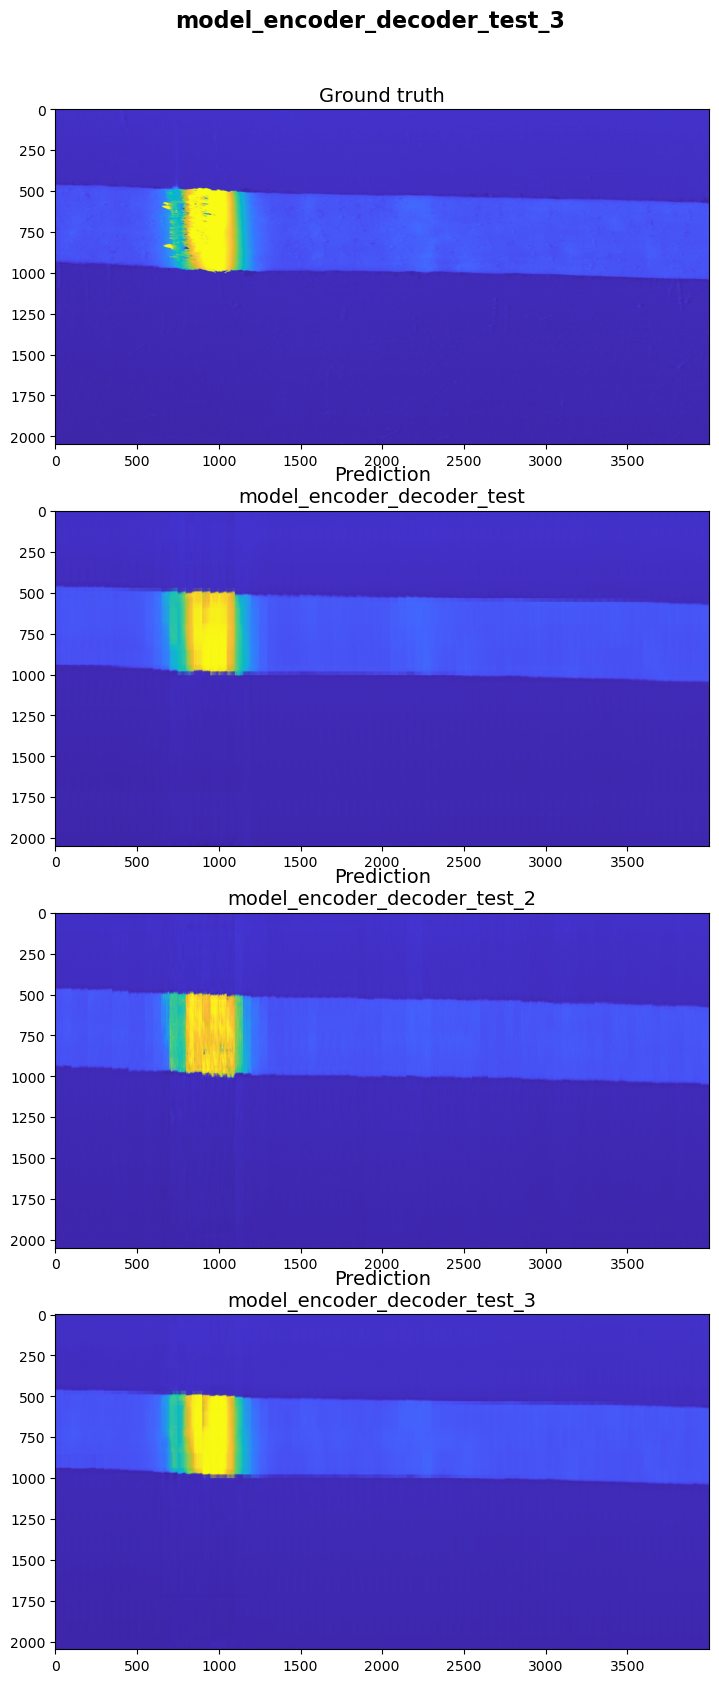

In [15]:
test_case = test_list[0]
stride_step = 50
print(f'Chosen test case: {test_case}\n')


path_list = ['PuckerImages//RGB_cropped',
             'TwistImages//RGB',
             'FoldImages//RGB',]
for path in path_list:
    if test_case[:4]==path[:4]:
        break

img = Image.open(f'{path}//{test_case}')
image_data_gt = np.array(img, dtype=dtype)
#crop the end
image_data_gt = image_data_gt[:,:-96,:]
print(f'Image shape: {image_data_gt.shape}')
#get frames
image_data_frames_gt = get_frames(image_data_gt, stride_step, ifPrint = False)
print(f'Framed image shape: {image_data_frames_gt.shape}')


numb_col = len(model_dict.keys())+1    
fig, axes = plt.subplots(numb_col,1, figsize=(10,5*numb_col))
fig.subplots_adjust(hspace=0.2, wspace=0.25)
linewidth = 3.0
fontsize_sec = 14
fig.suptitle(f'{model_name}', fontsize=fontsize_sec+2, fontweight='bold', y=0.93)

ax = axes[0]
ax.imshow(image_data_gt)
ax.set_title(f'Ground truth', fontsize=fontsize_sec)

#prediction
for ii, model_name in enumerate(model_dict.keys()):
    model = model_dict[model_name]
    print(f'\nModel name: {model_name}')
       
    print('##########Prediction started#############')
    tic = time.perf_counter()
    for i, frame_data_gt in enumerate(image_data_frames_gt):
        frame_data_predicted = model.predict(np.expand_dims(frame_data_gt, axis=0),verbose = 0)

        if i==0:
            image_data_frames_predicted = frame_data_predicted
        else:
            image_data_frames_predicted = np.append(image_data_frames_predicted, frame_data_predicted, axis=0)
    toc = time.perf_counter()
    print('##########Image predicted#############')
    print(f'Time for prediction (whole image): {toc - tic:.2f} sec')

    #reshape from separate frames into a single image
    print('\nReshaping separate frames into a single image')
    tic = time.perf_counter()
    original_shape = image_data_frames_predicted.shape
    #swap axis
    image_data_rsh1 = np.swapaxes(image_data_frames_predicted,1,2)
    print(f'Image shape after 1st reshape: {image_data_rsh1.shape}')
    #reshape
    image_data_rsh2 = image_data_rsh1.reshape(original_shape[0]*original_shape[2], original_shape[1], original_shape[3])
    print(f'Image shape after 2st reshape: {image_data_rsh2.shape}')
    #swap axis back
    image_data_predicted = np.swapaxes(image_data_rsh2,0,1)
    print(f'Image shape after final reshape: {image_data_predicted.shape}')
    #convert float to in
    image_data_predicted=image_data_predicted.astype(int)
    toc = time.perf_counter()
    print(f'Time for image assembly: {toc - tic:.2f} sec')

    ax = axes[ii+1]
    ax.imshow(image_data_predicted)
    ax.set_title(f'Prediction\n{model_name}', fontsize=fontsize_sec)

Chosen test case: Fold1.png

Image shape: (2048, 4000, 3)
Framed image shape: (80, 2048, 50, 3)

Model name: model_encoder_decoder_test
##########Prediction started#############
##########Image predicted#############
Time for prediction (whole image): 3.24 sec

Reshaping separate frames into a single image
Image shape after 1st reshape: (80, 50, 2048, 3)
Image shape after 2st reshape: (4000, 2048, 3)
Image shape after final reshape: (2048, 4000, 3)
Time for image assembly: 0.09 sec

Model name: model_encoder_decoder_test_2
##########Prediction started#############
##########Image predicted#############
Time for prediction (whole image): 3.28 sec

Reshaping separate frames into a single image
Image shape after 1st reshape: (80, 50, 2048, 3)
Image shape after 2st reshape: (4000, 2048, 3)
Image shape after final reshape: (2048, 4000, 3)
Time for image assembly: 0.09 sec

Model name: model_encoder_decoder_test_3
##########Prediction started#############
##########Image predicted###########

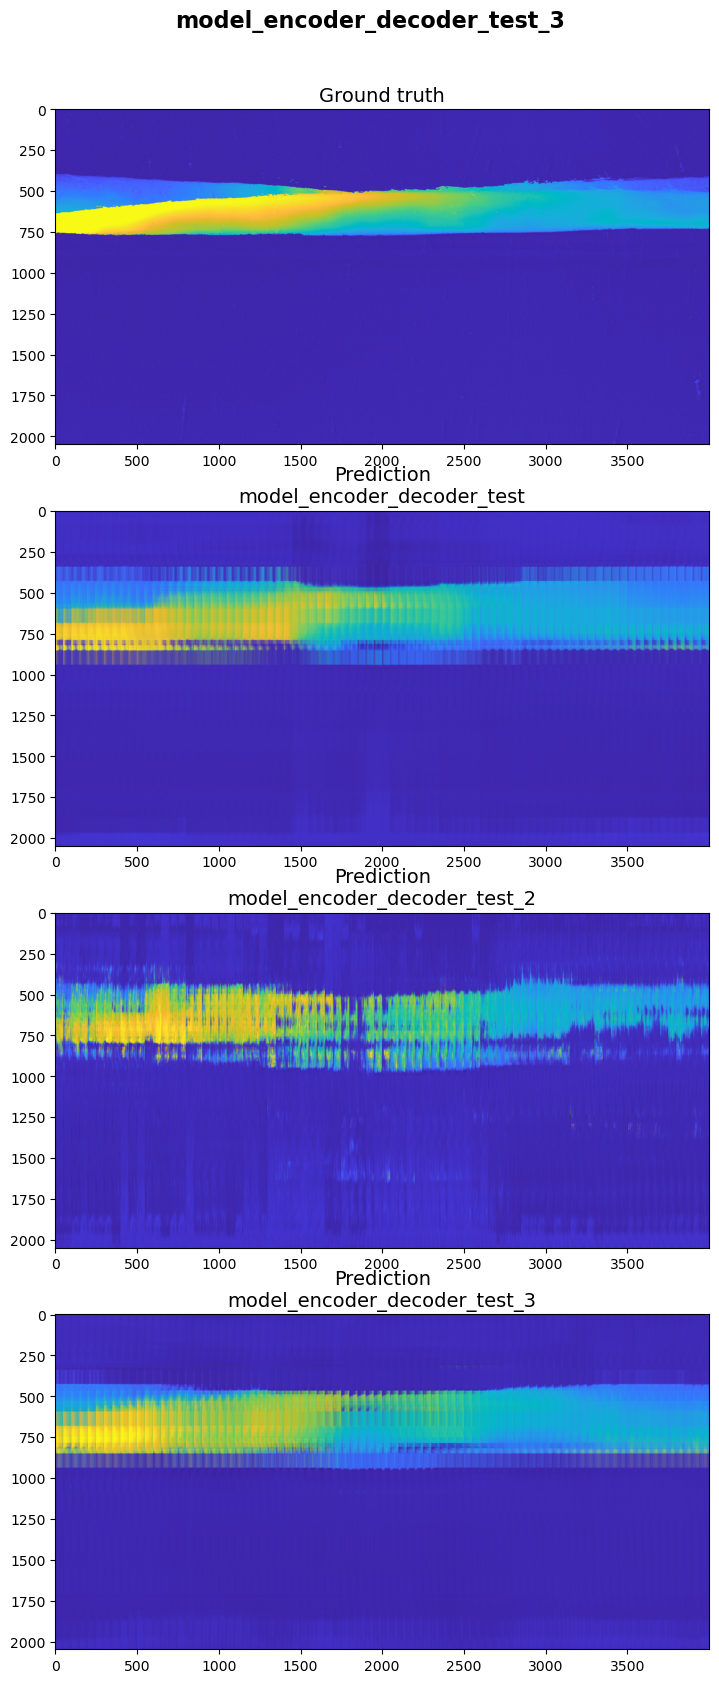

In [10]:
test_case = 'Fold1.png'
stride_step = 50
print(f'Chosen test case: {test_case}\n')


path_list = ['PuckerImages//RGB_cropped',
             'TwistImages//RGB',
             'FoldImages//RGB',]
for path in path_list:
    if test_case[:4]==path[:4]:
        break

img = Image.open(f'{path}//{test_case}')
image_data_gt = np.array(img, dtype=dtype)
#crop the end
image_data_gt = image_data_gt[:,:-96,:]
print(f'Image shape: {image_data_gt.shape}')
#get frames
image_data_frames_gt = get_frames(image_data_gt, stride_step, ifPrint = False)
print(f'Framed image shape: {image_data_frames_gt.shape}')


numb_col = len(model_dict.keys())+1    
fig, axes = plt.subplots(numb_col,1, figsize=(10,5*numb_col))
fig.subplots_adjust(hspace=0.2, wspace=0.25)
linewidth = 3.0
fontsize_sec = 14
fig.suptitle(f'{model_name}', fontsize=fontsize_sec+2, fontweight='bold', y=0.93)

ax = axes[0]
ax.imshow(image_data_gt)
ax.set_title(f'Ground truth', fontsize=fontsize_sec)

#prediction
for ii, model_name in enumerate(model_dict.keys()):
    model = model_dict[model_name]
    print(f'\nModel name: {model_name}')
       
    print('##########Prediction started#############')
    tic = time.perf_counter()
    for i, frame_data_gt in enumerate(image_data_frames_gt):
        frame_data_predicted = model.predict(np.expand_dims(frame_data_gt, axis=0),verbose = 0)

        if i==0:
            image_data_frames_predicted = frame_data_predicted
        else:
            image_data_frames_predicted = np.append(image_data_frames_predicted, frame_data_predicted, axis=0)
    toc = time.perf_counter()
    print('##########Image predicted#############')
    print(f'Time for prediction (whole image): {toc - tic:.2f} sec')

    #reshape from separate frames into a single image
    print('\nReshaping separate frames into a single image')
    tic = time.perf_counter()
    original_shape = image_data_frames_predicted.shape
    #swap axis
    image_data_rsh1 = np.swapaxes(image_data_frames_predicted,1,2)
    print(f'Image shape after 1st reshape: {image_data_rsh1.shape}')
    #reshape
    image_data_rsh2 = image_data_rsh1.reshape(original_shape[0]*original_shape[2], original_shape[1], original_shape[3])
    print(f'Image shape after 2st reshape: {image_data_rsh2.shape}')
    #swap axis back
    image_data_predicted = np.swapaxes(image_data_rsh2,0,1)
    print(f'Image shape after final reshape: {image_data_predicted.shape}')
    #convert float to in
    image_data_predicted=image_data_predicted.astype(int)
    toc = time.perf_counter()
    print(f'Time for image assembly: {toc - tic:.2f} sec')

    ax = axes[ii+1]
    ax.imshow(image_data_predicted)
    ax.set_title(f'Prediction\n{model_name}', fontsize=fontsize_sec)

Chosen test case: Twist5.png

Image shape: (2048, 4000, 3)
Framed image shape: (80, 2048, 50, 3)

Model name: model_encoder_decoder_test
##########Prediction started#############
##########Image predicted#############
Time for prediction (whole image): 3.25 sec

Reshaping separate frames into a single image
Image shape after 1st reshape: (80, 50, 2048, 3)
Image shape after 2st reshape: (4000, 2048, 3)
Image shape after final reshape: (2048, 4000, 3)
Time for image assembly: 0.10 sec

Model name: model_encoder_decoder_test_2
##########Prediction started#############
##########Image predicted#############
Time for prediction (whole image): 3.28 sec

Reshaping separate frames into a single image
Image shape after 1st reshape: (80, 50, 2048, 3)
Image shape after 2st reshape: (4000, 2048, 3)
Image shape after final reshape: (2048, 4000, 3)
Time for image assembly: 0.09 sec

Model name: model_encoder_decoder_test_3
##########Prediction started#############
##########Image predicted##########

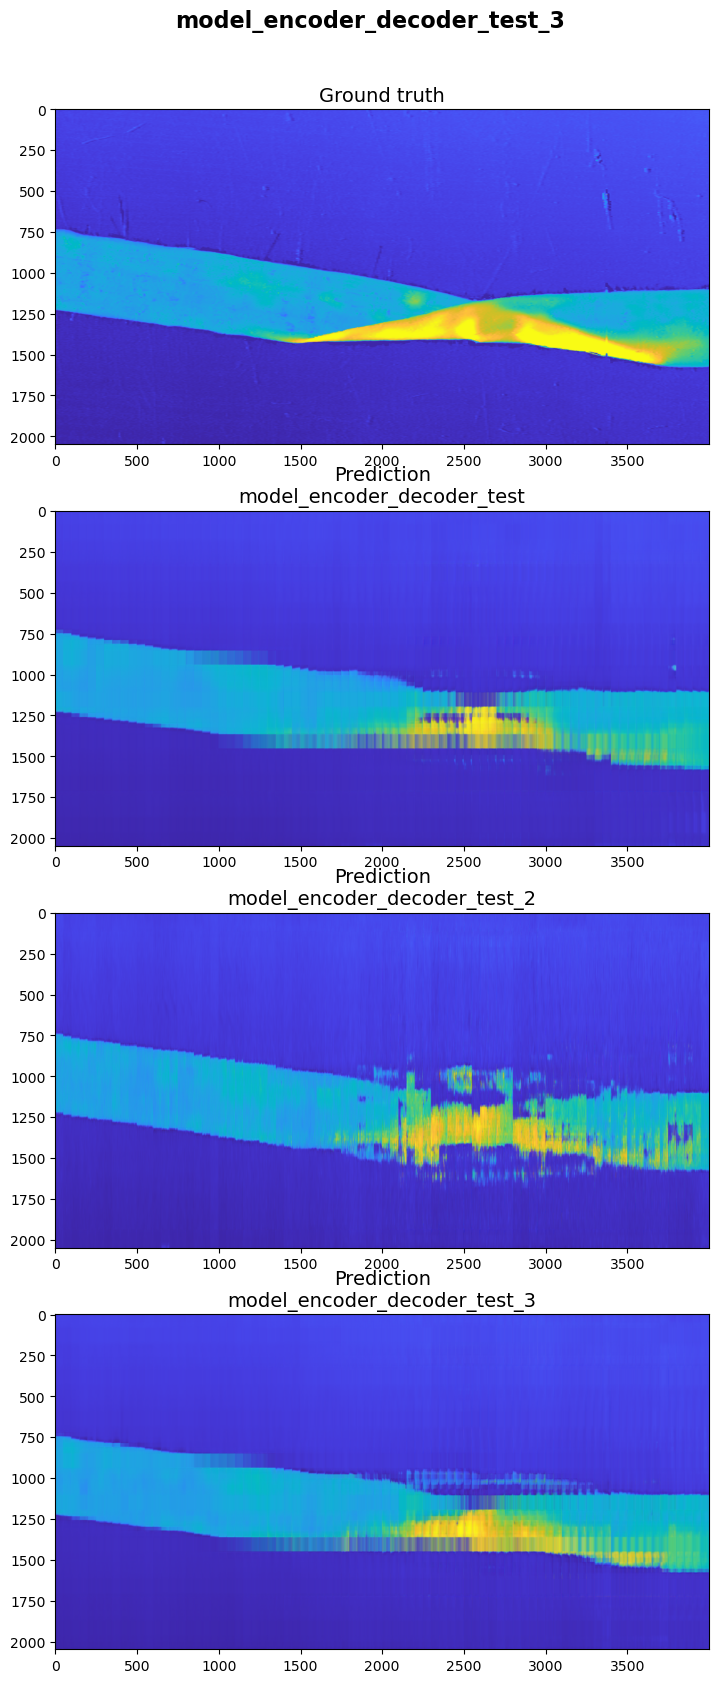

In [11]:
test_case = 'Twist5.png'
stride_step = 50
print(f'Chosen test case: {test_case}\n')


path_list = ['PuckerImages//RGB_cropped',
             'TwistImages//RGB',
             'FoldImages//RGB',]
for path in path_list:
    if test_case[:4]==path[:4]:
        break

img = Image.open(f'{path}//{test_case}')
image_data_gt = np.array(img, dtype=dtype)
#crop the end
image_data_gt = image_data_gt[:,:-96,:]
print(f'Image shape: {image_data_gt.shape}')
#get frames
image_data_frames_gt = get_frames(image_data_gt, stride_step, ifPrint = False)
print(f'Framed image shape: {image_data_frames_gt.shape}')


numb_col = len(model_dict.keys())+1    
fig, axes = plt.subplots(numb_col,1, figsize=(10,5*numb_col))
fig.subplots_adjust(hspace=0.2, wspace=0.25)
linewidth = 3.0
fontsize_sec = 14
fig.suptitle(f'{model_name}', fontsize=fontsize_sec+2, fontweight='bold', y=0.93)

ax = axes[0]
ax.imshow(image_data_gt)
ax.set_title(f'Ground truth', fontsize=fontsize_sec)

#prediction
for ii, model_name in enumerate(model_dict.keys()):
    model = model_dict[model_name]
    print(f'\nModel name: {model_name}')
       
    print('##########Prediction started#############')
    tic = time.perf_counter()
    for i, frame_data_gt in enumerate(image_data_frames_gt):
        frame_data_predicted = model.predict(np.expand_dims(frame_data_gt, axis=0),verbose = 0)

        if i==0:
            image_data_frames_predicted = frame_data_predicted
        else:
            image_data_frames_predicted = np.append(image_data_frames_predicted, frame_data_predicted, axis=0)
    toc = time.perf_counter()
    print('##########Image predicted#############')
    print(f'Time for prediction (whole image): {toc - tic:.2f} sec')

    #reshape from separate frames into a single image
    print('\nReshaping separate frames into a single image')
    tic = time.perf_counter()
    original_shape = image_data_frames_predicted.shape
    #swap axis
    image_data_rsh1 = np.swapaxes(image_data_frames_predicted,1,2)
    print(f'Image shape after 1st reshape: {image_data_rsh1.shape}')
    #reshape
    image_data_rsh2 = image_data_rsh1.reshape(original_shape[0]*original_shape[2], original_shape[1], original_shape[3])
    print(f'Image shape after 2st reshape: {image_data_rsh2.shape}')
    #swap axis back
    image_data_predicted = np.swapaxes(image_data_rsh2,0,1)
    print(f'Image shape after final reshape: {image_data_predicted.shape}')
    #convert float to in
    image_data_predicted=image_data_predicted.astype(int)
    toc = time.perf_counter()
    print(f'Time for image assembly: {toc - tic:.2f} sec')

    ax = axes[ii+1]
    ax.imshow(image_data_predicted)
    ax.set_title(f'Prediction\n{model_name}', fontsize=fontsize_sec)